<h1>A Solar Study</h1>

<p>The idea behind this project is to look at the link between the weather and the solar installation on the top of my house.  The site, located in Toronto, Canada, has been operational for 2 years now and generates approximately 125% of my annual electricity needs.  While it's been performing well, there are a few questions that I would like to answer, such as:</p>

<ul>
    <li>How does the ambient temperature impact the solar array?</li>
    <li>Can we detect efficiency degradation?</li>
    <li>How accurately can we predict the generation using models of historical generation data and the weather forcast?</li>
</ul>

<p>Because the weather is statistical in nature, panel variation can vary widely from day to day and year to year.  This makes it challenging to measure such things as panel degradation without taking the weather into account.  Furthermore, I can envison a time in which more of the grid is produced by solar.  An appropriate model and the week's weather forecast would allow energy companies to premptively power up or down energy sinks/generation stations which might require a longer time constant to turn on/off (ie. nuclear plants).</p>

<p>
    To perform the study, we'll first need to collect the data.  This will be obtained from three sources:
<ol>
<li>Historical weather data for the site - scrapped from a weather website.</li>
<li>The solar data for the site - via the inverter's API</li>
<li>Data generated from a solar model of the site  which will provide a "best case" estimate of the site's capacity.</li>
</ol>
</p>

In [1]:
from bs4 import BeautifulSoup as soup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
import json
import sqlite3
sns.set(color_codes=True)

<h2>1. Historical Weather Data</h2><p>The historical weather data comes from the Pearson airport weather station and the site <a href="https://www.timeanddate.com/weather/canada/toronto/historic">www.timeanddate.com</a>.  It's surprisingly challenging to get a weather site with a free API, so I scrapped the site (VIA HTML) and then stored it for future reference in an SQL database.  More detail of that work can be found in :historical_weather_data.ipynb.</p><p>For the analysis, we need to import the data for the appropriate time period and then massage it a little bit (by quantifying the categorical data).</p>

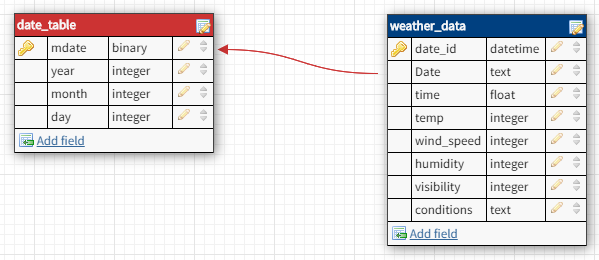

In [2]:
DB = "toronto_weather.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

In [3]:
show_tables()

,name,type
0,date_table,table
1,weather_data,table


Let's plot the Monthly Mean Temperature and Humidity for the SQL data to confirm everything is kosher.

In [4]:
q = """
WITH data_month AS (
SELECT 
    wd.temp,
    wd.humidity,
    dt.year,
    dt.month
    FROM weather_data wd
    LEFT JOIN date_table dt ON dt.mdate=wd.Date
)
SELECT year,month,ROUND(AVG(temp),1) ave_temp,ROUND(AVG(humidity),1) ave_humid
FROM data_month
GROUP BY month,year
"""
average_temp = run_query(q)

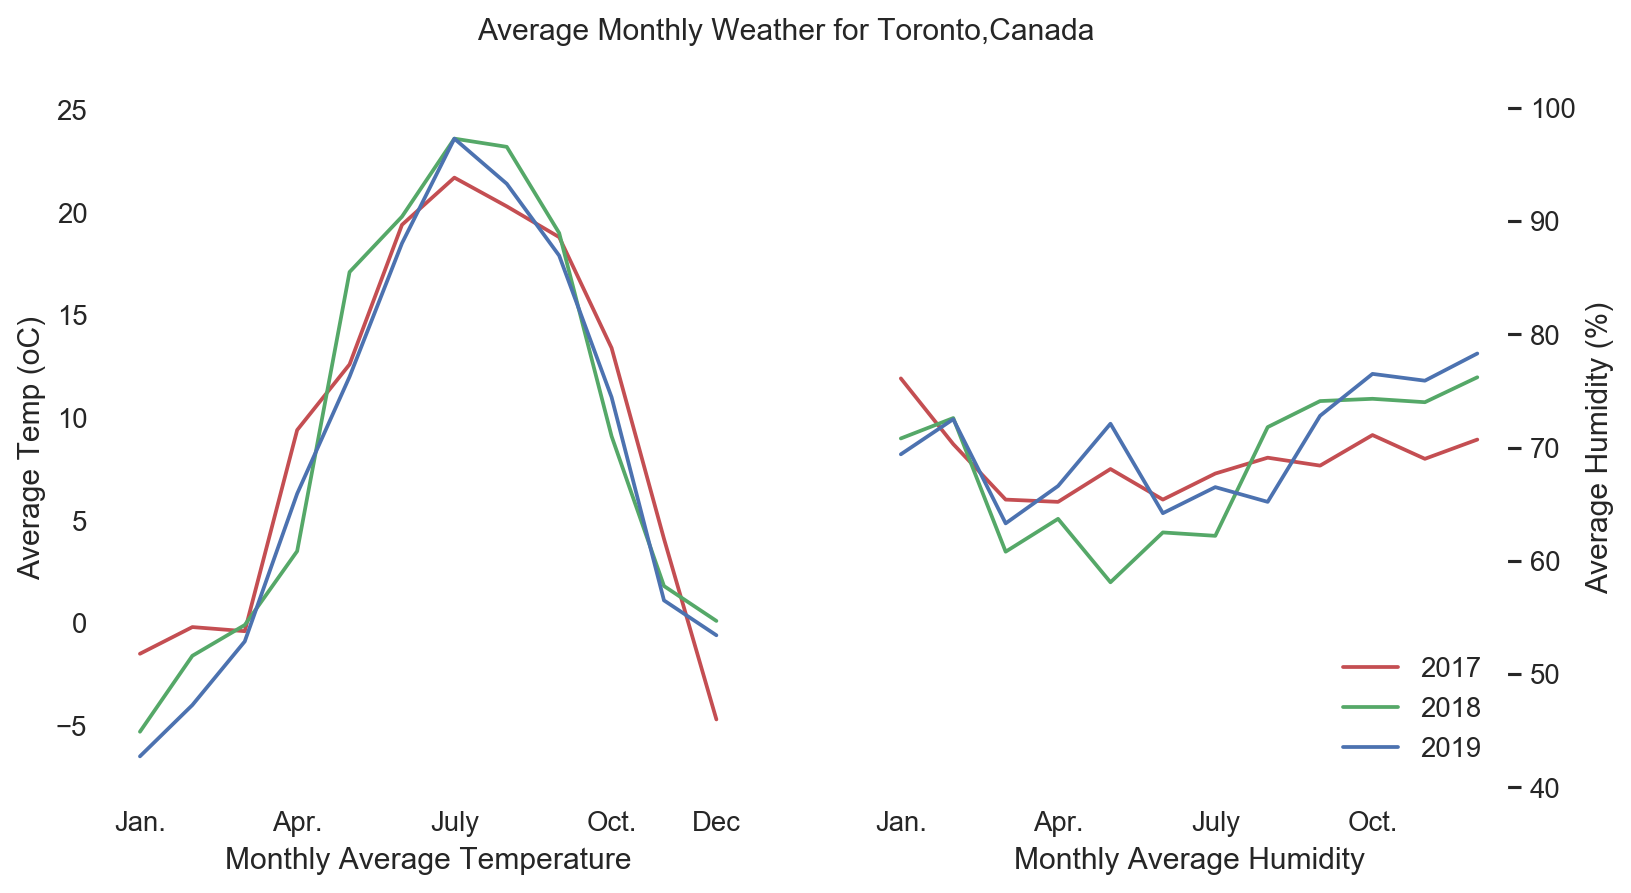

In [5]:
fig = plt.figure(figsize=(10,5),dpi=180)
ax1 = fig.add_subplot(1,2,1)
c = ['r','g','b']
for i in average_temp['year'].unique():
    data = average_temp[average_temp['year']==i][['month','ave_temp','ave_humid']]
    ax1.plot(data['month'],data['ave_temp'],c[i-2017],label=i)
plt.xlabel('Monthly Average Temperature')
plt.ylabel('Average Temp (oC)')
ax1.set_xticks([1,4,7,10,12])
ax1.set_xticklabels(['Jan.','Apr.','July','Oct.','Dec'])
sns.despine()
ax2 = fig.add_subplot(1,2,2)
for i in average_temp['year'].unique():
    data = average_temp[average_temp['year']==i][['month','ave_temp','ave_humid']]
    ax2.plot(data['month'],data['ave_humid'],c[i-2017],label=i)
ax2.set_xticks([1,4,7,10])
ax2.set_xticklabels(['Jan.','Apr.','July','Oct.'])
ax2.set_ylim(40,100)
ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.xlabel('Monthly Average Humidity')
plt.ylabel('Average Humidity (%)')
f = plt.legend(loc='lower right',frameon=1)
frame = f.get_frame()
frame.set_facecolor('white')
frame.set_linewidth(0)
plt.suptitle('Average Monthly Weather for Toronto,Canada')
plt.show()

In [6]:
# collect data from 2018/2019

q = """
SELECT
    wd.date_id,
    wd.temp,
    wd.humidity,
    wd.wind_speed,
    wd.visability,
    wd.conditions
FROM weather_data wd
LEFT JOIN date_table dt  ON dt.mdate = wd.Date
WHERE (dt.year LIKE "2018") OR (dt.year LIKE "2019")
"""

full_wdata = run_query(q)
full_wdata.set_index('date_id',inplace=True)

<h3>Removing the categorical variable</h3>
<p>Looking at weather data for 2018/2019.  The data looks good, but there's a categorical variable that needs to be parsed as it has 134 different variants.  I'd like to assign them a score of between 0 and 4 along the basic principle:
<ul>
<li>Clear/Sunny: 4</li>
<li>Partly Sunny/Partly Cloudy: 3</li>
<li>Mostly Cloudy/overcast: 2</li>
<li>light Rain/Cloudy: 1</li>
<li>Rain/Snow:0</li></ul>
Then these values will be applied to the data</p>

In [7]:
catmap = {}
cnt = 0
unique_items = list(full_wdata['conditions'].unique())
for i,item in enumerate(unique_items):
    if 'cloud' in item.lower(): #is it cloudy?
        if ('low' in item.lower()) | ('mostly' in item.lower()) :
            catmap[item] = 1
        elif ('than sun' in item.lower())| ('scatter' in item.lower()):
            catmap[item] = 2
        elif ('pass' in item.lower()) | ('partly' in item.lower()) | ('broken' in item.lower()):
            catmap[item] = 3
        elif ('cloudy' in item.lower()) | ('high' in item.lower()) :
            catmap[item] = 2
        else:
            print(item)
    else:
        if ('fog' in item.lower()) & ('heavy' not in item.lower()):
            catmap[item] = 1
        elif ('partly sunny' in item.lower()) | ('haze' in item.lower()):
            catmap[item] = 3
        elif ('clear' in item.lower()):
            catmap[item] = 4
        elif ('cast' in item.lower()) |  ('heavy snow' in item.lower()):
            catmap[item] = 0
        elif ('rain' in item.lower()):
            catmap[item] = 1
        else:
            catmap[item] = 4
            
full_wdata['conditions'] = full_wdata['conditions'].replace(catmap)

In [8]:
#check it worked
full_wdata['conditions'].describe()

count    17520.000000
mean         2.281963
std          1.223500
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: conditions, dtype: float64

Looking at the quartiles, this seems fairly reasonable (we have a median of  3)

<h2>2. The Solar Data</h2>
<p>Now we need to add the Solar Data to compare against.  We do this by adding in the solar reader class I wrote which interfaces with the modules via the SolarEdge API.
</p>

In [9]:
from solarReader import solarsite #custom solardatagrabber
sdata = solarsite('2018-01-01','2019-12-31')

The site was active from 2017-12-12 to 2020-02-27.
The site was active from 2018-01-01 to 2019-12-31.


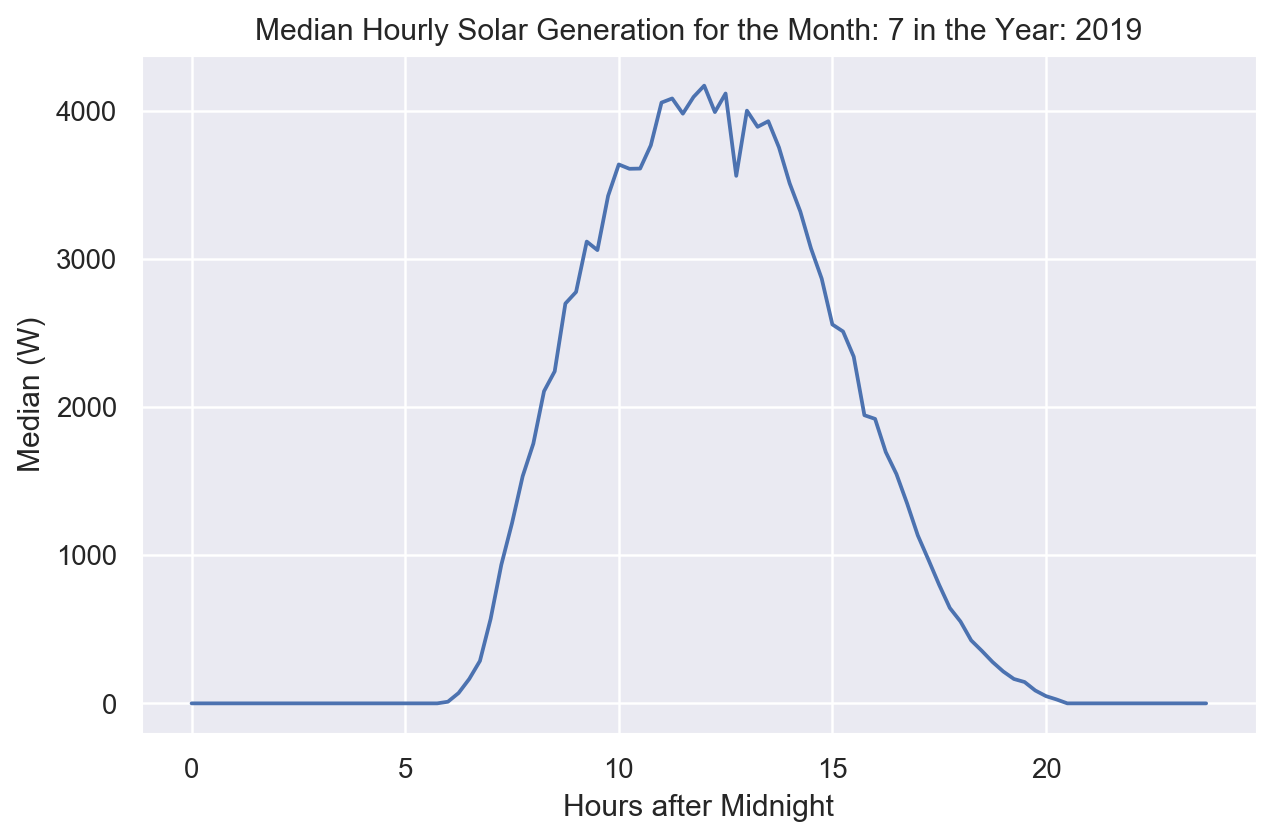

In [10]:
#check it works
#plot July, 2018
sdata.plot_data(2019,7)
ax2.set_facecolor('white')

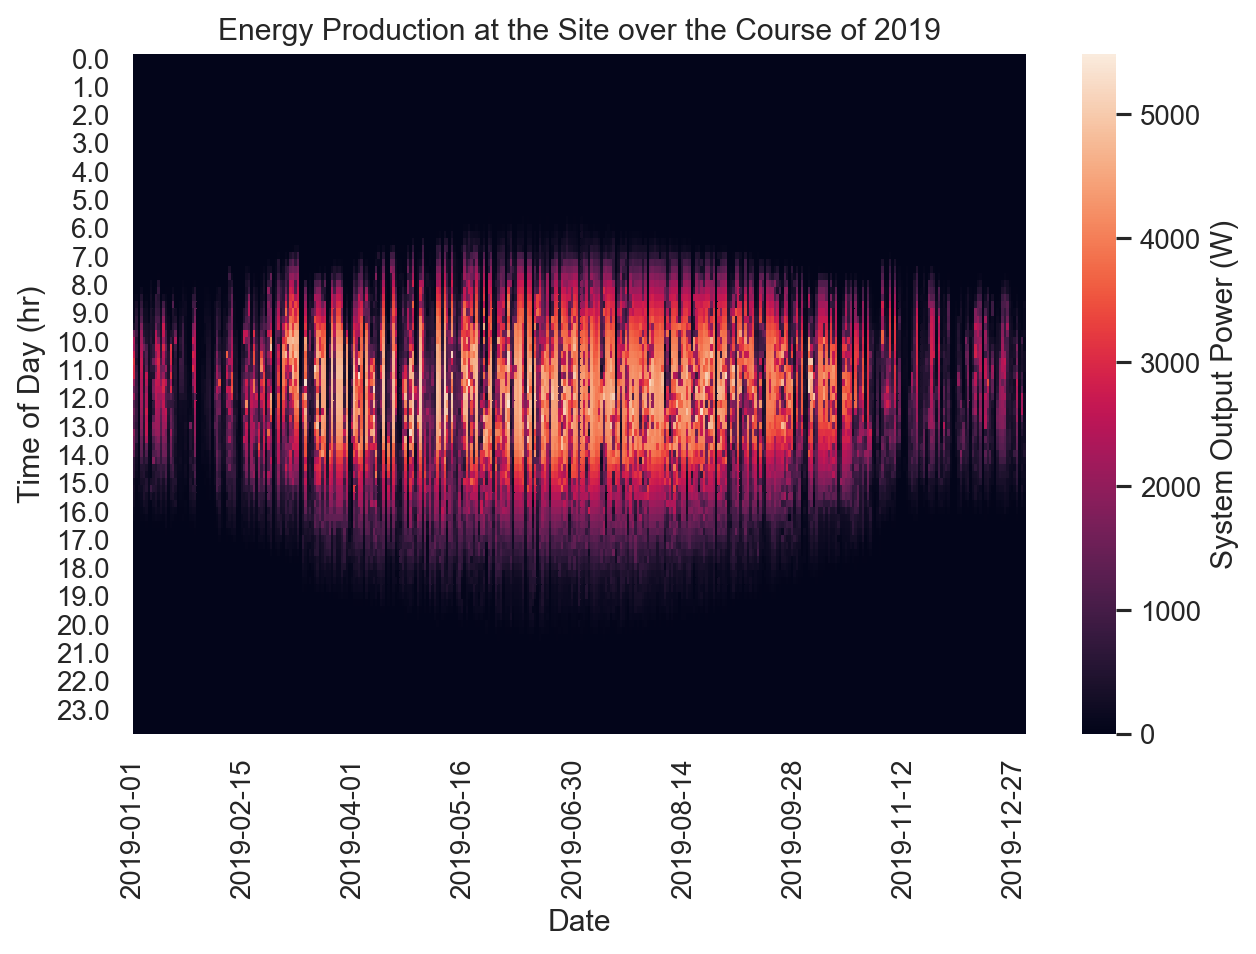

In [11]:
data = sdata.filter_data(2019)
data = data.reset_index(drop=True)
data_pivot = pd.pivot_table(sdata.filter_data(2019),values='value', index='Time',columns='Date')
cols = data_pivot.columns
fig = plt.figure(figsize=(8,5),dpi=180)
sns.heatmap(data_pivot,cbar_kws={"label": "System Output Power (W)"})
ax = plt.gca()
ax.set_xticks(range(0,len(cols),int(len(cols)/8)))
ax.set_xticklabels(cols[range(0,len(cols),int(len(cols)/8))])
ax.set_ylabel('Time of Day (hr)')
plt.title('Energy Production at the Site over the Course of 2019')
plt.show()

<h3>Resampling the solar data</h3>
<p>Unlike the weather data, the solar data is available in quarterly increments, so we'll need to resample the data.  I'll do this by converting from the instantaneous power it produces (W) to the energy (kWh) by integrating (via simpson's method) the power produce in the 30min before and after that hour.  Note, I need to shift the data in order to use the resample/sum function and have it centered on the time.</p>

In [12]:
sampdata = sdata.data.copy()
sampdata['real_panel_power'] = 0
sampl_err = 1.028 #this is to account for sampling error and brings the reported aata inline with the system power
for i in range(sampdata.shape[0]-1):
    if i % 2 == 1:
        lsum = sampl_err*(sampdata.iloc[i-1,2]+4*sampdata.iloc[i,2]+sampdata.iloc[i+1,2])/6000
        #print(i,sampdata.iloc[i-1,2],sampdata.iloc[i,2],sampdata.iloc[i+1,2],lsum,lsum*.5)
        sampdata.iloc[i,3] = lsum*0.5
sampdata = (((sampdata.shift(2)).resample('H',label='left').sum())).fillna(0)

<h3>Now Join the Data Sets Based on the Date</h3>


In [13]:
swdata = pd.concat([full_wdata,sampdata['real_panel_power']], axis=1, sort=False)
swdata.iloc[2365:2370,:]

,temp,humidity,wind_speed,visability,conditions,real_panel_power
2018-04-09 13:00:00,1,41,7,24,3,3.803288
2018-04-09 14:00:00,2,41,11,24,1,3.118461
2018-04-09 15:00:00,2,38,9,24,2,2.680173
2018-04-09 16:00:00,2,38,9,24,2,1.845634
2018-04-09 17:00:00,3,33,13,24,3,1.159156


<h2>3. Importing the Model</h2>

<p>I built a class which models the "solar efficiency", that is the relative solar irradiance absorbed by the panels at a given date and time.  It does this by calculating the solar elevation and azimuth angles (taking into consideration such things as the eccentricity of the earths orbit and the relative position of the site within it's time zone).  It then looks at the projection of the solar vector onto the normal vector of the panels. This (times the number of panels and a correction factor due to the varying mass of the atmosphere) gives the relative solar radiance experienced by the panels.</p>

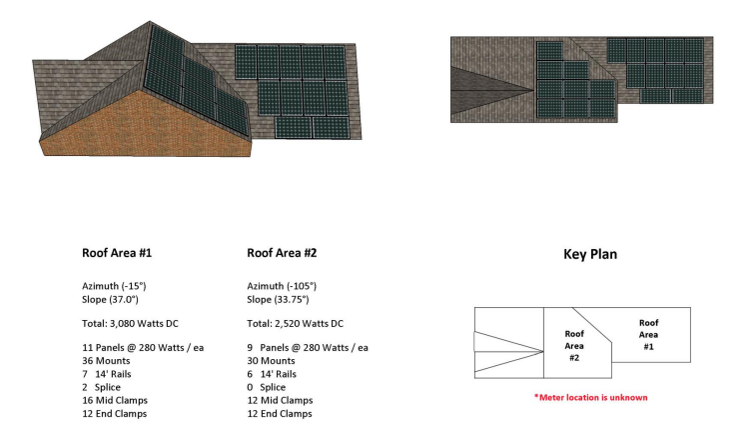

In [14]:
from solarPosition import solarefficiency as solareff

<p>First we test the model by comparing it against two clear days, one in the summer and one in the late winter.  These models are roughly scaled to fit.  We're looking at a correspondence between their slopes and widths, and not concerned with the exact numbers.</p><p> They fit pretty well. That said, the panels are rated for 280W, which lies inbetween the scale factors of 255 (hot therefore lower efficiency) and 300 (cold therefore higher efficiency).  Some shading from neighbouring buildings can be seen in the model, especially in February when the solar elevation angle is lower. Note - this also demonstrates we've properly taken daylight savings into account.</p>

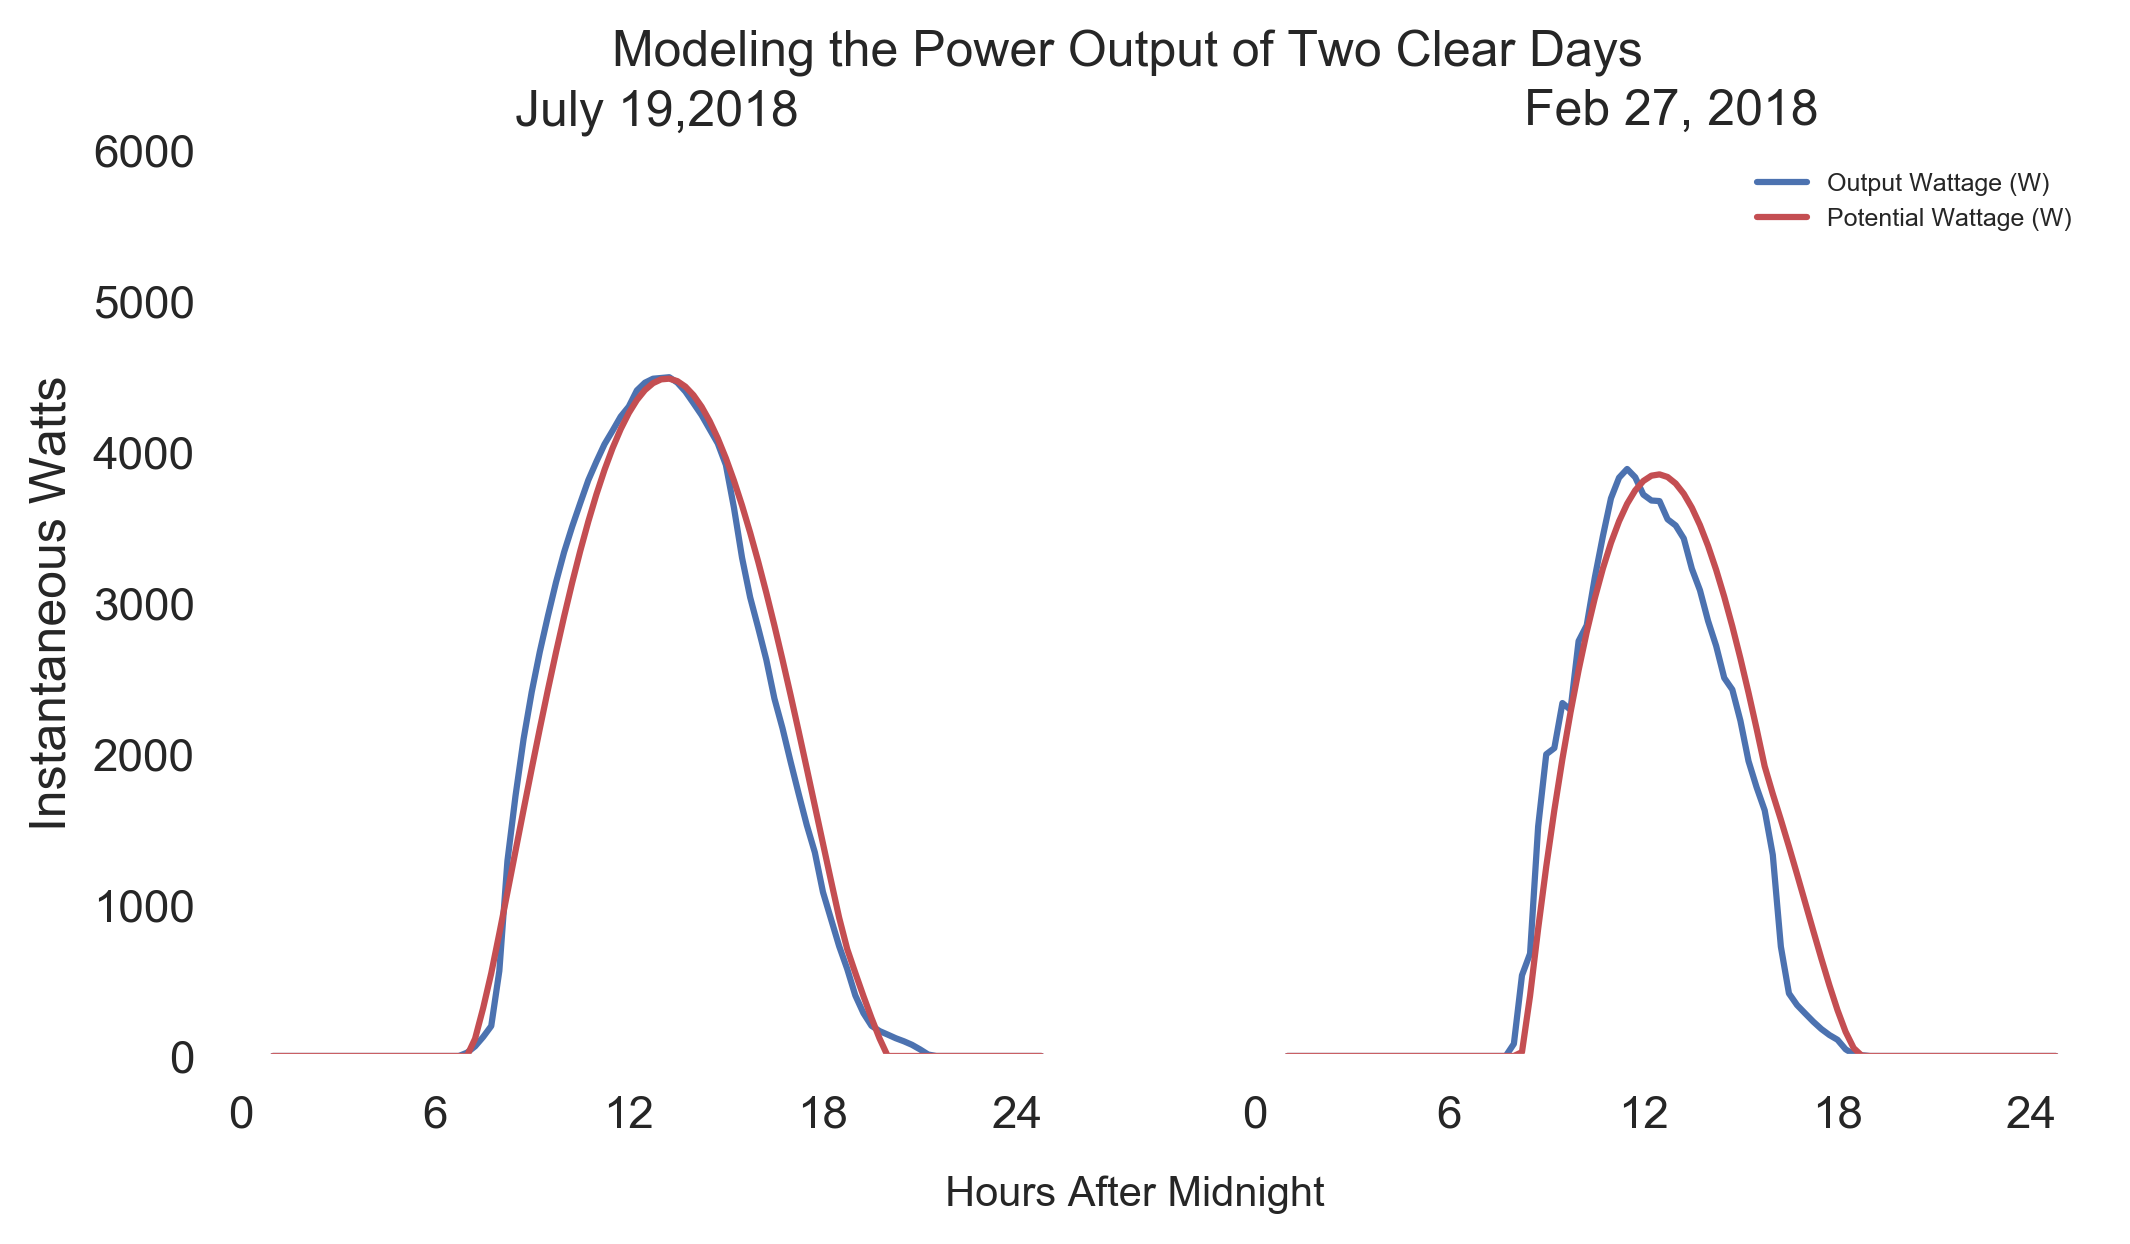

In [15]:
july = sdata.filter_data(2018,7,19)
july['eff'] = 0
fig = plt.figure(figsize=(8,4),dpi=300)
ax1 = fig.add_subplot(1,2,1)

for i in july.index:
    july.loc[i,'eff'] = solareff(i.strftime("%Y-%m-%d %H:%M")).sol_eff_tot*255
ax1.plot(july['value'],'b',label='Output Wattage (W)')
ax1.plot(july['eff'],'r',label='Potential Wattage (W)')
loc,labels = plt.xticks()
ax1.set_xticks([loc[0],loc[2],loc[4],loc[6],loc[8]])
ax1.set_xticklabels(['0','6','12','18','24'])
ax1.set_ylim(0,6000)
ax1.set_ylabel('Instantaneous Watts')
ax1.set_facecolor('white')
plt.title('July 19,2018')

feb = sdata.filter_data(2018,2,27)
feb['eff'] = 0
ax2 = fig.add_subplot(1,2,2)

for i in feb.index:
    feb.loc[i,'eff'] = solareff(i.strftime("%Y-%m-%d %H:%M")).sol_eff_tot*300
ax2.plot(feb['value'],'b',label='Output Wattage (W)')
ax2.plot(feb['eff'],'r',label='Potential Wattage (W)')
loc,labels = plt.xticks()
ax2.set_xticks([loc[0],loc[2],loc[4],loc[6],loc[8]])
ax2.set_xticklabels(['0','6','12','18','24'])
ax2.set_ylim(0,6000)
ax2.axes.get_yaxis().set_visible(False)
plt.title('Feb 27, 2018')
ax1.grid(False)
ax2.grid(False)
ax2.set_facecolor('white')
fig.text(0.5, 0.00, 'Hours After Midnight', ha='center')
f = plt.legend(loc='upper right',fontsize=6,frameon=1)
frame = f.get_frame()
frame.set_facecolor('white')
frame.set_linewidth(0)
plt.suptitle('Modeling the Power Output of Two Clear Days ')
plt.show()

Now we need to add this to the dataset.  To do this we need to calculate the values using the solar data set and then resample in the same way to match the weather data.

In [16]:
data2 = sdata.data.copy()
data2['est'] = 0
for m in data2.index:
    data2.loc[m,'est'] = solareff(m.strftime("%Y-%m-%d %H:%M")).sol_eff_tot*280
sampl_err = 1.028 #this is to account for sampling error and brings the reported aata inline with the system power

In [17]:
data2['max_panel_power'] = 0
for i in range(data2.shape[0]-1):
    if i % 2 == 1:
        lsum = sampl_err*(data2.iloc[i-1,3]+4*data2.iloc[i,3]+data2.iloc[i+1,3])/6000
        data2.iloc[i,4] = lsum*0.5
data2 = (((data2.shift(2)).resample('H',label='left').sum())).fillna(0)

In [18]:
swdata = pd.concat([swdata,data2['max_panel_power']], axis=1, sort=False)
swdata.iloc[2365:2370,:]

,temp,humidity,wind_speed,visability,conditions,real_panel_power,max_panel_power
date,,,,,,,
2018-04-09 13:00:00,1,41,7,24,3,3.803288,4.496217
2018-04-09 14:00:00,2,41,11,24,1,3.118461,3.993760
2018-04-09 15:00:00,2,38,9,24,2,2.680173,3.178644
2018-04-09 16:00:00,2,38,9,24,2,1.845634,2.146381
2018-04-09 17:00:00,3,33,13,24,3,1.159156,1.174383


<h2>Looking at the Data</h2>
<p>
    
</p>

First let's look at the data to determine how well the different variables correlate with each other.

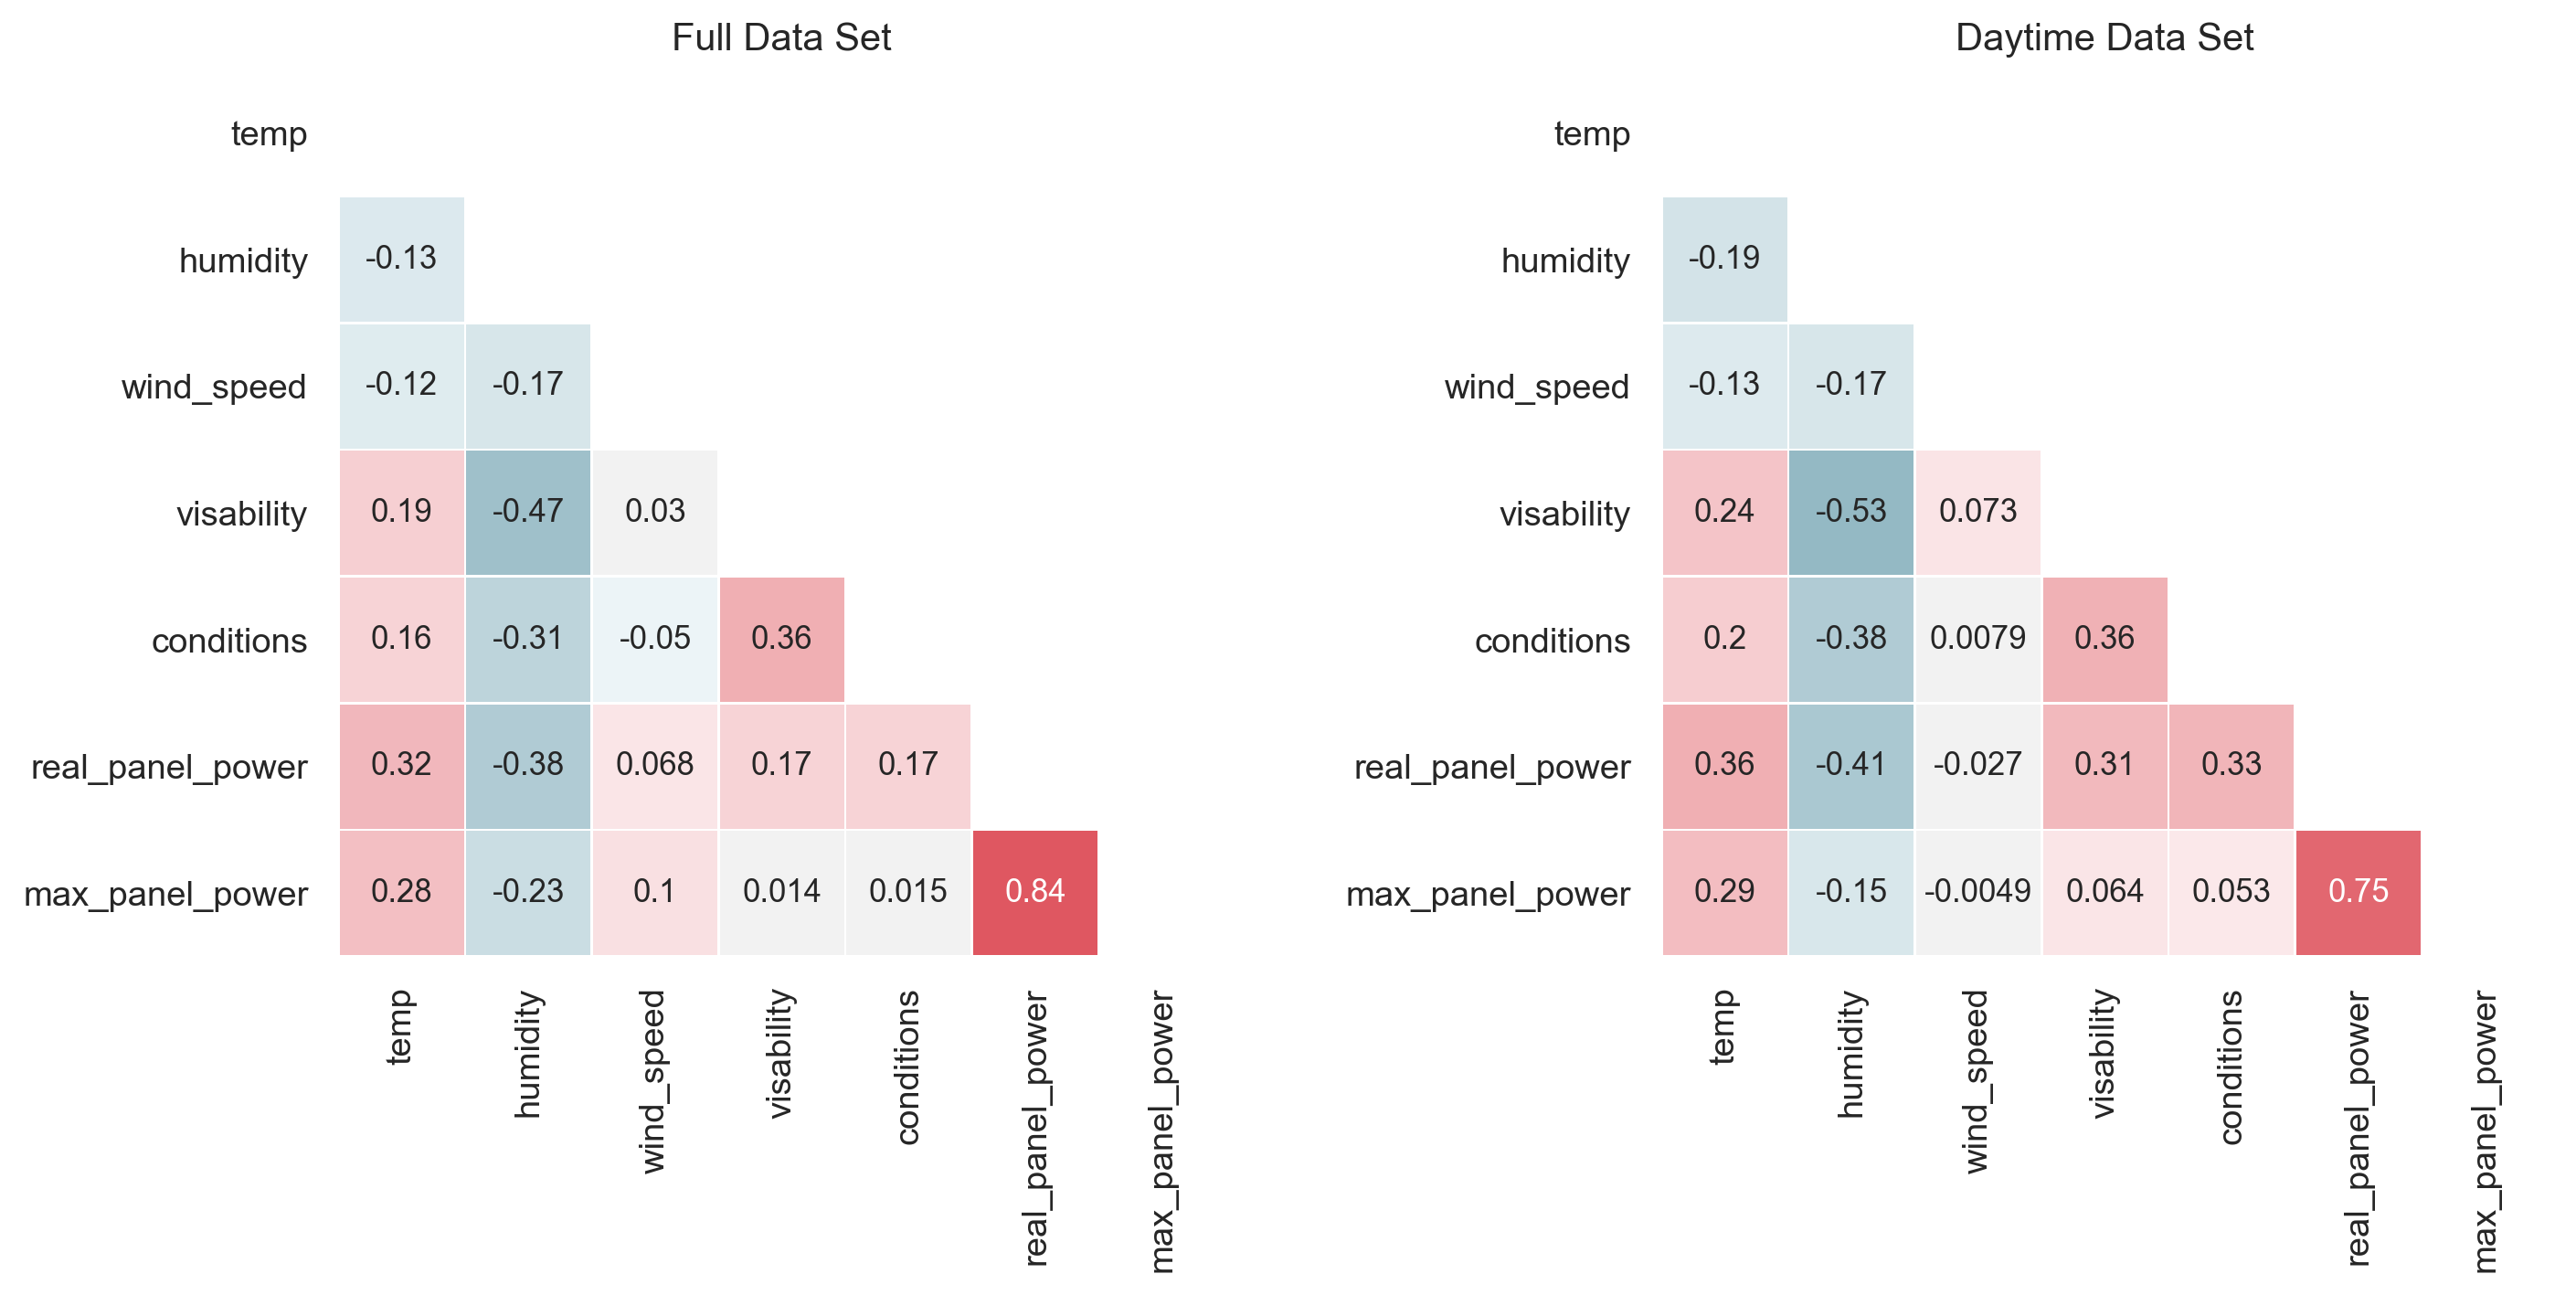

In [19]:
fig4 = plt.figure(figsize=(12,6),dpi=250)
ax1 = fig4.add_subplot(1,2,1)
corr1 = swdata.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(swdata.corr(), dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1,mask=mask,annot=True,square=True,cmap=cmap,vmax=1, center=0,linewidths=.5,  cbar=False,ax=ax1)
plt.title('Full Data Set')
plt.gca().set_facecolor('white')

ax2 = fig4.add_subplot(1,2,2)
swdataf = swdata[swdata['max_panel_power']!=0]
corr2 = swdataf.corr()
sns.heatmap(corr2,mask=mask,annot=True,square=True,cmap=cmap,vmax=1, center=0,linewidths=.5, cbar= False,ax=ax2)
plt.title('Daytime Data Set')
plt.gca().set_facecolor('white')
fig4.tight_layout(pad=3.0)
plt.show()

<p>Here I've further filtered the data to eliminate night time hours.  This makes sense since the other factors will have no bearing on panel out if there's no sun!  As expected the corrlations with real panel power increase when filtered except for
with max panel power (whose decrease makes sense since we're no longer correlating when power values are 0!).  Also of note is the moderately strong negative correlation with humidity (aka clouds).  Since wind_speed has no corrlelation with the panel output power, I'll drop it from the data set.</p>

In [20]:
final_dataset = swdataf[['temp', 'humidity', 'visability', 'conditions','max_panel_power','real_panel_power']]

<h2>Building a Machine Model</h2>

In [218]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate as CV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [219]:
#create a pipeline to scale the variables for better weighting.
num_pipline = Pipeline([('std_scaler',StandardScaler())])
#scale data
fdatasc = num_pipline.fit_transform(final_dataset.iloc[:,:-1])
datal = final_dataset.iloc[:,-1]

In [220]:
feb16 = pd.read_csv('20200216.csv','\t').set_index('time')
feb16[['max power','mean power']] = feb16[['max power','mean power']]/1000
feb16.columns=final_dataset.columns
feb16s =  num_pipline.fit_transform(final_dataset.append(feb16,ignore_index=True).iloc[:,:-1])[-12:,:]
feb16l = feb16.iloc[:,-1]

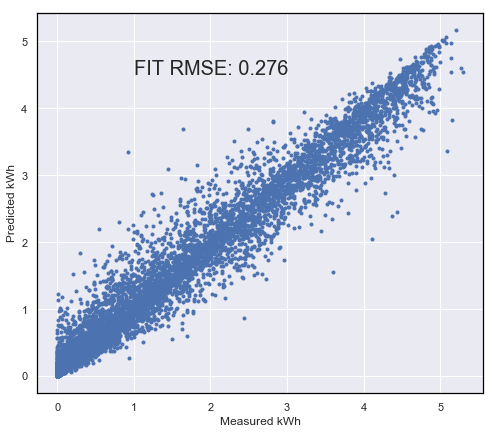

In [232]:
from sklearn.ensemble import RandomForestRegressor
sns.set_style('darkgrid', {'axes.linewidth': 2, 'axes.edgecolor':'black'})
fig6 = plt.figure(figsize=(8,7))
forest_reg = RandomForestRegressor()
forest_reg.fit(fdatasc,datal)
plt.plot(datal,forest_reg.predict(fdatasc),'b.')
plt.text(1,4.5,"FIT RMSE: %0.3f"%np.sqrt(mse(forest_reg.predict(fdatasc),datal)),fontsize=20)
plt.xlabel('Measured kWh')
plt.ylabel('Predicted kWh')
plt.show()

<p>So we get a decent fit of the training set.  Now let's look at a day outside of the training set (from last week).  We see that the model is able to predict the daily power generation to within 5% or so</p>

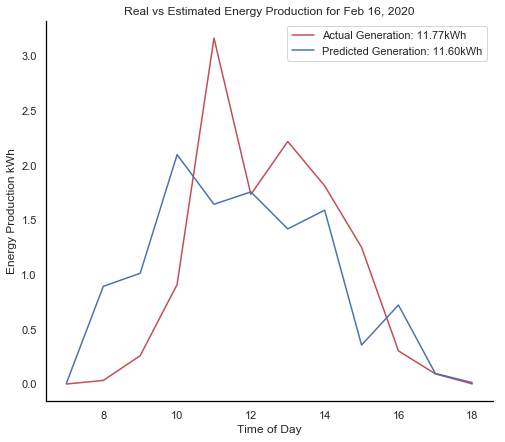

In [222]:
fig6 = plt.figure(figsize=(8,7))
sns.set_style('darkgrid', {'axes.linewidth': 2, 'axes.edgecolor':'black'})
plt.plot(np.arange(7,19),feb16l.values,'r-',label="Actual Generation: %0.2fkWh"%feb16l.sum())
plt.plot(np.arange(7,19),forest_reg.predict(feb16s),'b-',label="Predicted Generation: %0.2fkWh" %forest_reg.predict(feb16s).sum())
plt.gca().set_facecolor('white')
plt.xlabel('Time of Day')
plt.ylabel('Energy Production kWh')
plt.title('Real vs Estimated Energy Production for Feb 16, 2020')
f = plt.legend()
f.get_frame().set_facecolor('white')
sns.despine()
plt.show()

<h2>Good, but can we do better?</h2>

In [233]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,3,4,5]},{'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]},
]

forestreg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg,param_grid,cv=10,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(fdatasc,datal)
be = grid_search.best_estimator_

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4, 5]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

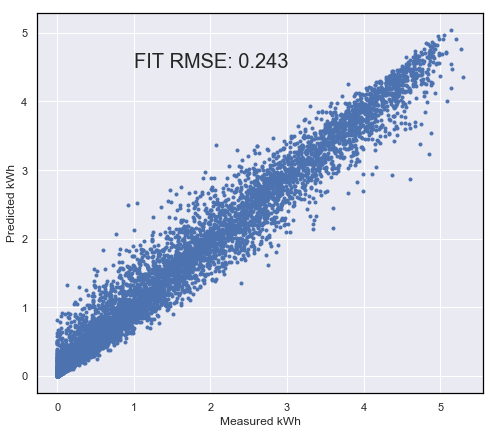

In [234]:
sns.set_style('darkgrid', {'axes.linewidth': 2, 'axes.edgecolor':'black'})
figw = plt.figure(figsize=(8,7))
forest_reg = RandomForestRegressor()
forest_reg.fit(fdatasc,datal)
plt.plot(datal,be.predict(fdatasc),'b.')
plt.xlabel('Measured kWh')
plt.ylabel('Predicted kWh')
plt.text(1,4.5,"FIT RMSE: %0.3f"%np.sqrt(mse(be.predict(fdatasc),datal)),fontsize=20)
plt.show()

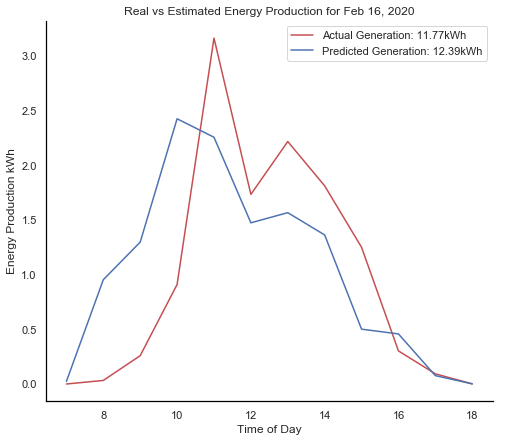

In [235]:
fig7 = plt.figure(figsize=(8,7))
sns.set_style('darkgrid', {'axes.linewidth': 2, 'axes.edgecolor':'black'})
plt.plot(np.arange(7,19),feb16l.values,'r-',label="Actual Generation: %0.2fkWh"%feb16l.sum())
plt.plot(np.arange(7,19),be.predict(feb16s),'b-',label="Predicted Generation: %0.2fkWh" %be.predict(feb16s).sum())
plt.gca().set_facecolor('white')
plt.xlabel('Time of Day')
plt.ylabel('Energy Production kWh')
plt.title('Real vs Estimated Energy Production for Feb 16, 2020')
f = plt.legend()
f.get_frame().set_facecolor('white')
sns.despine()
plt.show()

<h2>Conclusions</h2>

<p>Already we see that the random forest model does a pretty good job of fitting the data.  In the future I would like to expand the model to test its accuracy and its ability to discriminate a decrease in the system efficiency over the years.  That said, the model shows significant promise in terms of estimating the near-term solar generation (though this needs to be bourne out by testing against more data) and may already prove useful to a utility company.   There are a few further steps to increase the complexity of the model which would make it even more accurate.  The main source of error is likely shading which is not specifically modeled in any of the features, but is built into the descrepancy between the real and predicting "maximum" power curves.  In my theoretical model, I broke the site into two, but further breaking it down into individual panels and running an ensemble of models (for each panel) will increase the sensitivity to this shading. Furthermore, this prediction is made without the inclusion of any temporal feature.  As the shading increases during the winter, including a day/month/time component to the model will further increase the accuracy of its predictions.</p>